## motivation
Preliminary protocol/library QC to assess project feasibility

## setup

In [1]:
# modules
import pandas as pd
import numpy as np
from plotnine import *
import plotnine
import warnings
warnings.filterwarnings('ignore')

# functions
def a_content (string):
    a_count = string.count('A')
    total_count = len(string)
    
    return a_count/total_count

def gc_content (string):
    gc_count = string.count('G') + string.count('C')
    total_count = len(string)
    
    return gc_count/total_count
    
def process_df (df, colname):
    df['read_len'] = [len(x) for x in df[colname]]
    df['a_content'] = [a_content(x) for x in df[colname]]
    df['gc_content'] = [gc_content(x) for x in df[colname]]
    
    return df

# ingest data (10k sequences per R2 fastq, randomly subsampled)
trimmed_df = (pd.read_csv('s3://darmanis-group/danle/hockenmeyer_proj/seq_trimmed.txt', 
                          sep = '\n', 
                          header = None)
              .rename(columns = {0:'seq'})
             )
trimmed_df = process_df(trimmed_df, 'seq')
trimmed_df['src'] = 'trimmed'

untrimmed_df = (pd.read_csv('s3://darmanis-group/danle/hockenmeyer_proj/seq_untrimmed.txt', 
                            sep = '\n', 
                            header = None)
                .rename(columns = {0:'seq'})
               )
untrimmed_df = process_df (untrimmed_df, 'seq')
untrimmed_df['src'] = 'untrimmed'

merge_df = pd.concat([trimmed_df, untrimmed_df], axis = 0)

## example untrimmed sequences

In [2]:
[x for x in untrimmed_df.head(5).seq]

['CTCCTCCATTGCCCACTGACAATTTTTTTTTTTTTGCGGCGGGGGCACGGTCCCCCGCGAGGGGGGCCCAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAGGAAAAGAACAAAGGAGGAAAAGAAAAAAGAAAAAAAGAAGGGAAA',
 'CGGCAACATAGAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA',
 'CCGACTCTTAGCGGTGGATCACTCGGCTCGTGCGTCGATGAAGAACGCAGCTAGCTGCGAGAATTAATGTGAATTGCAGGACACATTGATCATCGACACTTCGAACGCACTTGCGGCCCCGGGTTCCTCCCGGGGCTACGCCTGTCTGAGC',
 'CGCTTCTGGGTCGGGGTTTCGTACGTAGCAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA',
 'CCCGGAAAATCAAGGCTGAGGCGTGATGACGAGGCACTACGGTGCTGAAGCAACAAATGCCCTGCTTCCAGGAAAAGCATCTAAGCATCAGGTAACATCAAATCGTACCCCAAACCGACACAGGTGGTCAGGTAAAAAAAAAAAAAAAAAA']

## trimmed statistics

In [3]:
trimmed_df.describe()

,read_len,a_content,gc_content
count,39923.000000,39923.000000,39923.000000
mean,68.086016,0.186379,0.618634
std,46.730656,0.111513,0.178027
min,1.000000,0.000000,0.000000
25%,28.000000,0.108108,0.500000
50%,59.000000,0.189189,0.591549
75%,97.000000,0.252476,0.736842
max,151.000000,0.777778,1.000000


## metric distributions

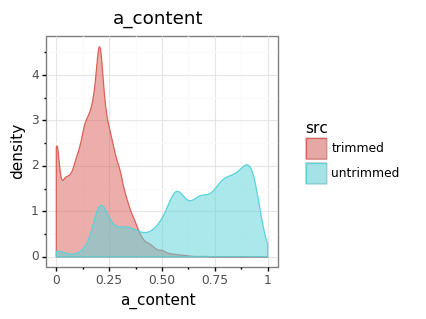

<ggplot: (8777090940224)>


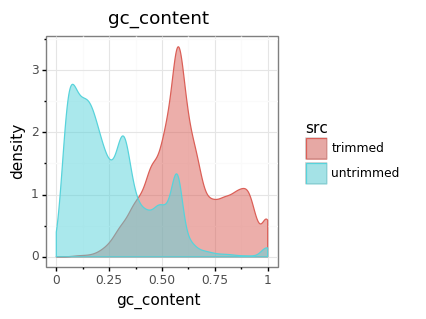

<ggplot: (8777090982152)>


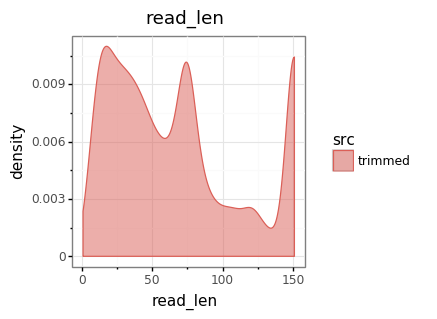

<ggplot: (8777091166335)>


In [4]:
# A content
for var in ['a_content','gc_content','read_len']:
    plotnine.options.figure_size = (3,3)
    plot = (ggplot(merge_df)
            + theme_bw()
            + geom_density(aes(var, fill = 'src', color = 'src'), alpha = 0.5)
            + ggtitle(var)
           )
    print(plot)

## distribution analysis

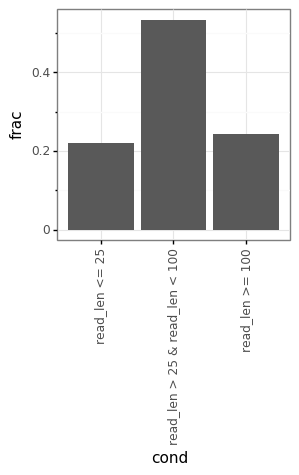

<ggplot: (8777085925468)>
                             cond      frac
0                  read_len <= 25  0.221326
1  read_len > 25 & read_len < 100  0.534329
2                 read_len >= 100  0.244345


In [11]:
## ref = https://chmi-sops.github.io/papers/readlength.pdf
# fraction "over-fragmented" (<= 25 bp)
# fraction "intermediate length" (25-99 bp)
# fraction "full length" (>=100 bp)
cond_list = ['read_len <= 25',
              'read_len > 25 & read_len < 100',
              'read_len >= 100'
             ]
frac_list = []
for x in cond_list:
    frac_list = frac_list + [len(trimmed_df.query(x))/len(trimmed_df)]
    
plot_df = pd.DataFrame({'cond':cond_list,
                        'frac':frac_list
                       })

plot = (ggplot(plot_df)
        + theme_bw()
        + theme(axis_text_x = element_text(angle=90))
        + geom_bar(aes('cond','frac'), stat = 'identity')
       )
print(plot)
print(plot_df)

## sequencing budget under-utilization

In [26]:
# combine coverage misallocation and unmappability
long_trimmed_df = trimmed_df.query('read_len > 25')

# reads covering polyA
misallocation = (len(long_trimmed_df) * 151) - long_trimmed_df.read_len.sum()

# unmappable short trimmed reads
unmappable = len(trimmed_df.query('read_len <= 25')) * 151

# fraction of wasted bases
round((misallocation + unmappable)/ untrimmed_df.read_len.sum(), 2)

# I expect ~50% of remaining reads to map to rRNA (based on provided previous analysis),
# leaving only about 22% of sequencing budget covering ROIs

0.57

## conclusion
Recommendation to suspend further analysis due to poor protocol/library statistics. Data suggests over-fragmentation of input RNA. 